# Tutorial for regression

In this tutorial, we compare the prediction intervals estimated by MAPIE on a 
simple, one-dimensional, ground truth function

$$
f(x) = x \sin(x)
$$

Throughout this tutorial, we will answer the following questions:

- How well do the MAPIE strategies capture the aleatoric uncertainty existing in the data?

- How do the prediction intervals estimated by the resampling strategies
  evolve for new *out-of-distribution* data? 

- How do the prediction intervals vary between regressor models?

Throughout this tutorial, we estimate the prediction intervals first using 
a polynomial function, and then using a boosting model, and a simple neural network. 

**For practical problems, we advise using the faster CV+ strategies. 
For conservative prediction interval estimates, you can alternatively 
use the CV-minmax strategies.**


## 1. Estimating the aleatoric uncertainty of homoscedastic noisy data

Let's start by defining the $x \times \sin(x)$ function and another simple function
that generates one-dimensional data with normal noise uniformely in a given interval.

In [1]:
from typing import List, Dict, Union

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

In [3]:
def get_1d_data_with_constant_noise(funct, min_x, max_x, n_samples, noise):
    """
    Generate 1D noisy data uniformely from the given function 
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

We first generate noisy one-dimensional data uniformely on an interval. 
Here, the noise is considered as *homoscedastic*, since it remains constant 
over $x$.

In [4]:
min_x, max_x, n_samples, noise = -5, 5, 600, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

Let's visualize our noisy function. 

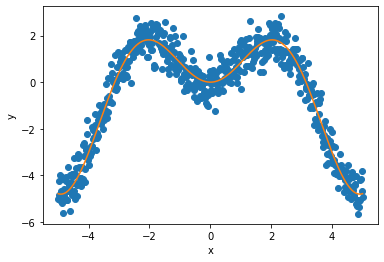

In [5]:
import matplotlib.pyplot as plt
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")

As mentioned previously, we fit our training data with a simple
polynomial function. Here, we choose a degree equal to 10 so the function 
is able to perfectly fit $x \times \sin(x)$.

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline

degree_polyn = 10
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression())
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs",
                alpha=0,
        ))
    ]
)

We then estimate the prediction intervals for all the strategies very easily with a
`fit` and `predict` process. The prediction interval's lower and upper bounds
are then saved in a DataFrame. Here, we set an alpha value of 0.05
in order to obtain a 95% confidence for our prediction intervals.

In [7]:
from typing import Union, Optional
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.subsample import Subsample 
from sklearn.model_selection import train_test_split
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        mapie.fit(X_train, y_train, random_state=1)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

Let’s now compare the target confidence intervals with the predicted intervals obtained 
with the Jackknife+, Jackknife-minmax, CV+, CV-minmax, Jackknife+-after-Boostrap, and conformalized quantile regression (CQR) strategies. Note that for the Jackknife-after-Bootstrap method, we call the :class:`mapie.subsample.Subsample` object that allows us to train bootstrapped models. Note also that the CQR method is called with `MapieQuantileRegressor` with a "split" strategy.

In [8]:
def plot_1d_data(
    X_train,
    y_train, 
    X_test,
    y_test,
    y_sigma,
    y_pred, 
    y_pred_low, 
    y_pred_up,
    ax=None,
    title=None
):
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
    if title is not None:
        ax.set_title(title)
    ax.legend()

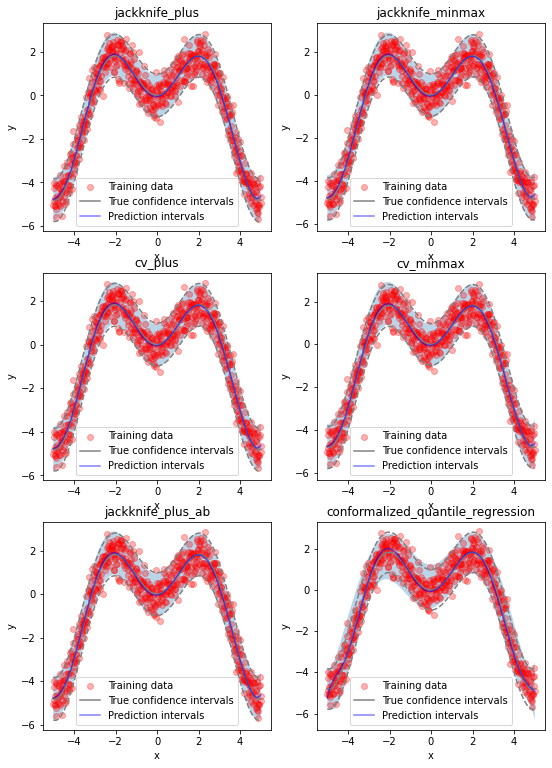

In [9]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        np.full((X_test.shape[0]), 1.96*noise).ravel(),
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, 0].ravel(),
        y_pis[strategy][:, 1, 0].ravel(),
        ax=coord,
        title=strategy
    )

At first glance, the four strategies give similar results and the
prediction intervals are very close to the true confidence intervals.
Let’s confirm this by comparing the prediction interval widths over
$x$ between all strategies.

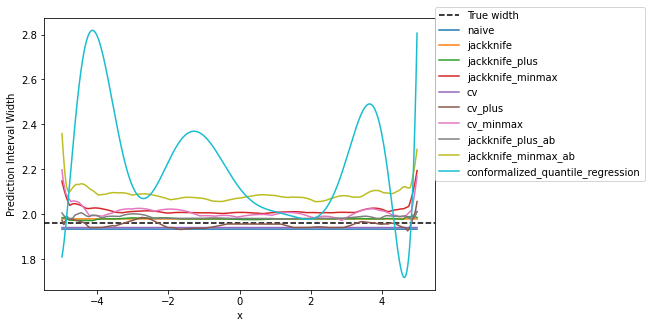

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.axhline(1.96*2*noise, ls="--", color="k", label="True width")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
_ = ax.legend(fontsize=10, loc=[1, 0.4])

As expected, the prediction intervals estimated by the Naive method
are slightly too narrow. The Jackknife, Jackknife+, CV, CV+, JaB, and J+aB give
similar widths that are very close to the true width. On the other hand,
the width estimated by Jackknife-minmax and CV-minmax are slightly too
wide. Note that the widths given by the Naive, Jackknife, and CV strategies
are constant because there is a single model used for prediction,
perturbed models are ignored at prediction time.

It's interesting to observe that CQR strategy offers more varying width,
often giving much higher but also lower interval width than other methods, therefore,
with homoscedastic noise, CQR would not be the preferred method.

Let’s now compare the *effective* coverage, namely the fraction of test
points whose true values lie within the prediction intervals, given by
the different strategies. 

In [11]:
import pandas as pd
from mapie.metrics import regression_coverage_score
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(2)

,Coverage,Width average
naive,0.93,1.93
jackknife,0.94,1.98
jackknife_plus,0.94,1.98
jackknife_minmax,0.94,2.02
cv,0.93,1.94
cv_plus,0.94,1.95
cv_minmax,0.94,2.01
jackknife_plus_ab,0.94,1.99
jackknife_minmax_ab,0.95,2.09
conformalized_quantile_regression,0.96,2.22


All strategies except the Naive one give effective coverage close to the expected 
0.95 value (recall that alpha = 0.05), confirming the theoretical garantees.

## 2. Estimating the aleatoric uncertainty of heteroscedastic noisy data

Let's define again the $x \times \sin(x)$ function and another simple function
that generates one-dimensional data with normal noise uniformely in a given interval.

In [12]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

In [13]:
def get_1d_data_with_heteroscedastic_noise(funct, min_x, max_x, n_samples, noise):
    """
    Generate 1D noisy data uniformely from the given function 
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train = funct(X_train) + (np.random.normal(0, noise, len(X_train)) * X_train)
    y_test = funct(X_test) + (np.random.normal(0, noise, len(X_test)) * X_test)
    y_mesh = funct(X_test)
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

We first generate noisy one-dimensional data uniformely on an interval. 
Here, the noise is considered as *heteroscedastic*, since it will increase linearly with $x$.

In [14]:
min_x, max_x, n_samples, noise = 0, 5, 300, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_heteroscedastic_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

Let's visualize our noisy function. As x increases, the data becomes more noisy.

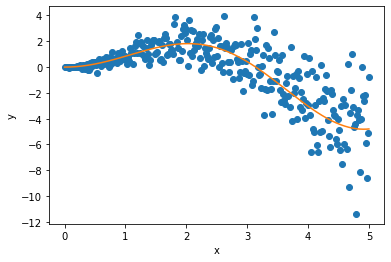

In [15]:
import matplotlib.pyplot as plt
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")

As mentioned previously, we fit our training data with a simple
polynomial function. Here, we choose a degree equal to 10 so the function 
is able to perfectly fit $x \times \sin(x)$.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline

degree_polyn = 10
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression())
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs",
                alpha=0,
        ))
    ]
)

We then estimate the prediction intervals for all the strategies very easily with a
`fit` and `predict` process. The prediction interval's lower and upper bounds
are then saved in a DataFrame. Here, we set an alpha value of 0.05
in order to obtain a 95% confidence for our prediction intervals.

In [17]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        mapie.fit(X_train, y_train, random_state=1)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

Once again, let’s compare the target confidence intervals with prediction intervals obtained with the Jackknife+, Jackknife-minmax, CV+, CV-minmax, Jackknife+-after-Boostrap, and CQR strategies.

In [18]:
def plot_1d_data(
    X_train,
    y_train, 
    X_test,
    y_test,
    y_sigma,
    y_pred, 
    y_pred_low, 
    y_pred_up,
    ax=None,
    title=None
):
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
    if title is not None:
        ax.set_title(title)
    ax.legend()

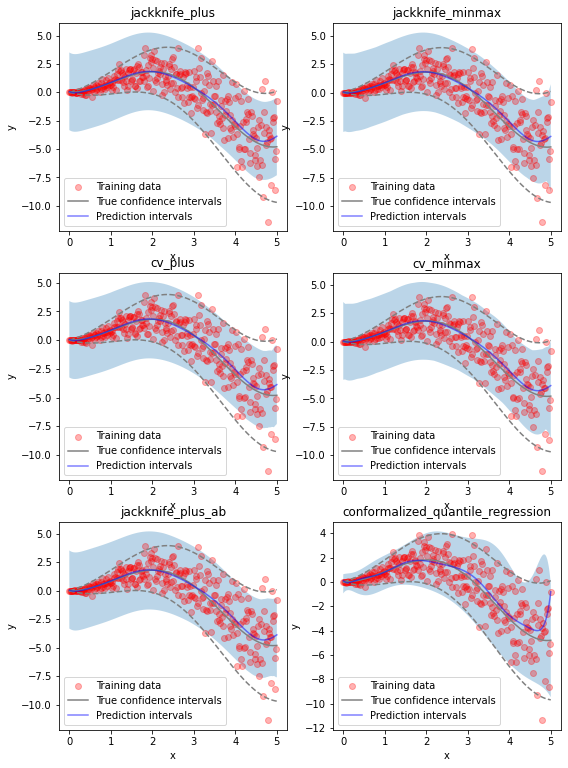

In [19]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        (1.96*noise*X_test).ravel(),
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, 0].ravel(),
        y_pis[strategy][:, 1, 0].ravel(),
        ax=coord,
        title=strategy
    )

We can observe that all of the strategies except CQR seem to have similar constant prediction intervals. 
On the other hand, the CQR strategy offers a solution that adapts the prediction
intervals to the local noise.

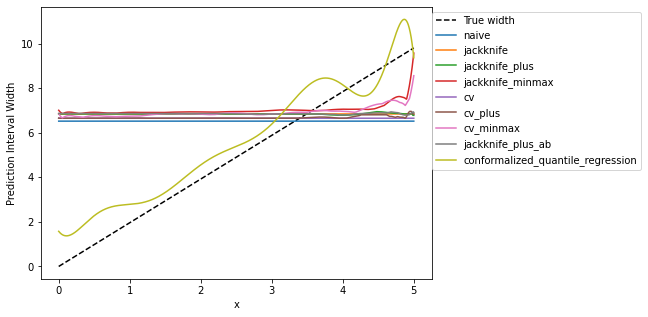

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(X_test, 1.96*2*noise*X_test, ls="--", color="k", label="True width")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
_ = ax.legend(fontsize=10, loc=[1, 0.4])

One can observe that all the strategies behave in a similar way as in the first example shown previously. One exception is the CQR method which takes into account the heteroscedasticity of the data. In this method we observe very low interval widths at low values of $x$. This is the only method that even slightly follows the true width, and therefore is the preferred method for heteroscedastic data. Notice also that the true width is greater (lower) than the predicted width from the other methods at $x \gtrapprox 3$ ($x \leq 3$). This means that while the marginal coverage correct for these methods, the conditional coverage is likely not guaranteed as we will observe in the next figure.

In [21]:
def get_heteroscedastic_coverage(y_test, y_pis, STRATEGIES, bins):
    recap ={}
    for i in range(len(bins)-1):
        bin1, bin2 = bins[i], bins[i+1]
        name = f"[{bin1}, {bin2}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where((X_test>=bins[i])*(X_test<=bins[i+1]))
            y_test_trunc = np.take(y_test, indices)
            y_low_ = np.take(y_pis[strategy][:, 0, 0], indices)
            y_high_ = np.take(y_pis[strategy][:, 1, 0], indices)
            score_coverage = regression_coverage_score(y_test_trunc[0], y_low_[0], y_high_[0])
            recap[name].append(score_coverage)
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df

In [22]:
bins = [0, 1, 2, 3, 4, 5]
heteroscedastic_coverage = get_heteroscedastic_coverage(y_test, y_pis, STRATEGIES, bins)

<Figure size 432x288 with 0 Axes>

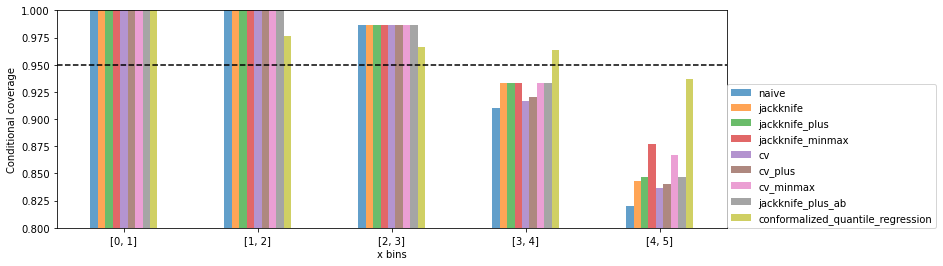

In [23]:
fig = plt.figure()
heteroscedastic_coverage.T.plot.bar(figsize=(12, 4), alpha=0.7)
plt.axhline(0.95, ls="--", color="k")
plt.ylim([0.8, 1])
plt.ylabel("Conditional coverage")
plt.xlabel("x bins")
plt.xticks(rotation=0)
plt.ylim(0.8, 1.0)
plt.legend(loc=[1, 0])

Let’s now conclude by summarizing the *effective* coverage, namely the fraction of test
points whose true values lie within the prediction intervals, given by
the different strategies. 

In [24]:
import pandas as pd
from mapie.metrics import regression_coverage_score
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(2)

,Coverage,Width average
naive,0.94,6.52
jackknife,0.95,6.84
jackknife_plus,0.95,6.84
jackknife_minmax,0.96,7.02
cv,0.95,6.65
cv_plus,0.95,6.68
cv_minmax,0.96,6.91
jackknife_plus_ab,0.95,6.85
conformalized_quantile_regression,0.97,5.54


All the strategies have the wanted coverage, however, we notice that the CQR strategy has much lower interval width than all the other methods, therefore, with heteroscedastic noise, CQR would be the preferred method.

## 3. Estimating the epistemic uncertainty of out-of-distribution data

Let’s now consider one-dimensional data without noise, but normally distributed.
The goal is to explore how the prediction intervals evolve for new data 
that lie outside the distribution of the training data in order to see how the strategies
can capture the *epistemic* uncertainty. 
For a comparison of the epistemic and aleatoric uncertainties, please have a look at this
[source](https://en.wikipedia.org/wiki/Uncertainty_quantification).

Lets" start by generating and showing the data. 

In [25]:
def get_1d_data_with_normal_distrib(funct, mu, sigma, n_samples, noise):
    """
    Generate noisy 1D data with normal distribution from given function 
    and noise standard deviation.
    """
    np.random.seed(59)
    X_train = np.random.normal(mu, sigma, n_samples)
    X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

In [26]:
mu = 0 ; sigma = 2 ; n_samples = 1000 ; noise = 0.
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_normal_distrib(
    x_sinx, mu, sigma, n_samples, noise
)

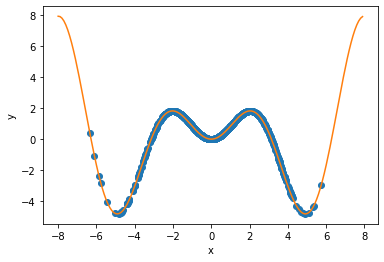

In [27]:
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_test, color="C1")

As before, we estimate the prediction intervals using a polynomial
function of degree 10 and show the results for the Jackknife+ and CV+
strategies.

In [28]:
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs-ds",
                alpha=0,
        ))
    ]
)
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        mapie.fit(X_train, y_train, random_state=1)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

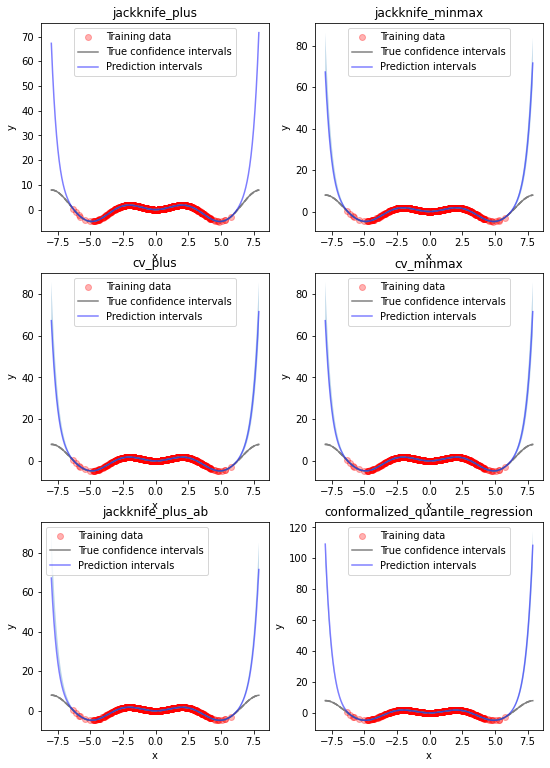

In [29]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords): 
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(), 
        X_test.ravel(),
        y_mesh.ravel(),
        1.96*noise, 
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, :].ravel(),
        y_pis[strategy][:, 1, :].ravel(), 
        ax=coord,
        title=strategy
    )

At first glance, our polynomial function does not give accurate
predictions with respect to the true function when $|x > 6|$. 
The prediction intervals estimated with the Jackknife+ do not seem to 
increase significantly, unlike the CV+ method whose prediction intervals
capture a high uncertainty when $x > 6$.

Let's now compare the prediction interval widths between all strategies. 


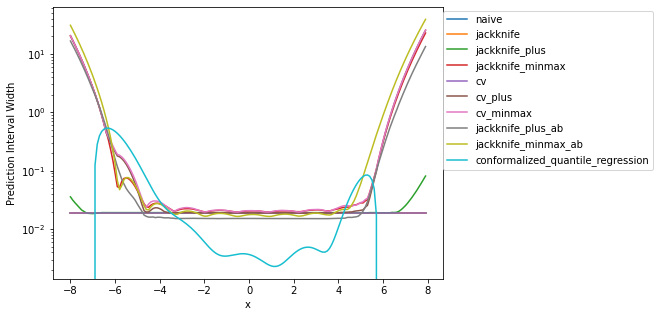

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_yscale("log")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
ax.legend(fontsize=10, loc=[1, 0.4]);

The prediction interval widths start to increase exponentially
for $|x| > 4$ for the CV+, CV-minmax, Jackknife-minmax, and quantile
strategies. On the other hand, the prediction intervals estimated by
Jackknife+ remain roughly constant until $|x| \sim 5$ before
increasing.
The CQR strategy seems to perform well, however, on the extreme values
of the data the quantile regression fails to give reliable results as it outputs
negative value for the prediction intervals. This occurs because the quantile 
regressor with quantile $1 - \alpha/2$ gives higher values than the quantile 
regressor with quantile $\alpha/2$. Note that a warning will be issued when
this occurs.

In [31]:
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(3)

,Coverage,Width average
naive,0.556,0.019
jackknife,0.562,0.019
jackknife_plus,0.562,0.021
jackknife_minmax,0.656,1.529
cv,0.562,0.019
cv_plus,0.638,1.627
cv_minmax,0.681,1.633
jackknife_plus_ab,0.625,1.101
jackknife_minmax_ab,0.731,2.586
conformalized_quantile_regression,0.688,-1.006


In conclusion, the Jackknife-minmax, CV+, CV-minmax, or Jackknife-minmax-ab strategies are more
conservative than the Jackknife+ strategy, and tend to result in more
reliable coverages for *out-of-distribution* data. It is therefore
advised to use the three former strategies for predictions with new
out-of-distribution data.
Note however that there are no theoretical guarantees on the coverage level 
for out-of-distribution data.
Here it's important to note that the CQR strategy should not be taken into account for
width prediction, and it is abundantly clear from the negative width coverage that
is observed in these results.

## 4. Estimating the uncertainty with different sklearn-compatible regressors

MAPIE can be used with any kind of sklearn-compatible regressor. Here, we
illustrate this by comparing the prediction intervals estimated by the CV+ method using
different models:

- the same polynomial function as before.
 
- a XGBoost model using the Scikit-learn API.

- a simple neural network, a Multilayer Perceptron with three dense layers, using the KerasRegressor wrapper.

Once again, let’s use our noisy one-dimensional data obtained from a
uniform distribution.

In [32]:
min_x, max_x, n_samples, noise = -5, 5, 100, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

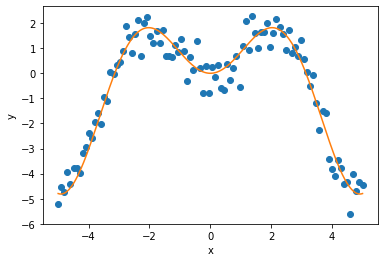

In [33]:
plt.xlabel("x") ; plt.ylabel("y")
plt.plot(X_test, y_mesh, color="C1")
_ = plt.scatter(X_train, y_train)

Let's then define the models. The boosing model considers 100 shallow trees with a max depth of 2 while
the Multilayer Perceptron has two hidden dense layers with 20 neurons each followed by a relu activation.


In [34]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # disable debugging logs from Tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
def mlp():
    """
    Two-layer MLP model
    """
    model = Sequential([
        Dense(units=20, input_shape=(1,), activation="relu"),
        Dense(units=20, activation="relu"),
        Dense(units=1)
    ])
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [35]:
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression())
    ]
)

In [36]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    max_depth=2,
    n_estimators=100,
    tree_method="hist",
    random_state=59,
    learning_rate=0.1,
    verbosity=0,
    nthread=-1
)
mlp_model = KerasRegressor(
    build_fn=mlp, 
    epochs=500, 
    verbose=0
)

Let's now use MAPIE to estimate the prediction intervals using the CV+ method 
and compare their prediction interval.

In [37]:
models = [polyn_model, xgb_model, mlp_model]
model_names = ["polyn", "xgb", "mlp"]
prediction_interval = {}
for name, model in zip(model_names, models):
    mapie = MapieRegressor(model, method="plus", cv=5)
    mapie.fit(X_train, y_train)
    y_pred[name], y_pis[name] = mapie.predict(X_test, alpha=0.05)

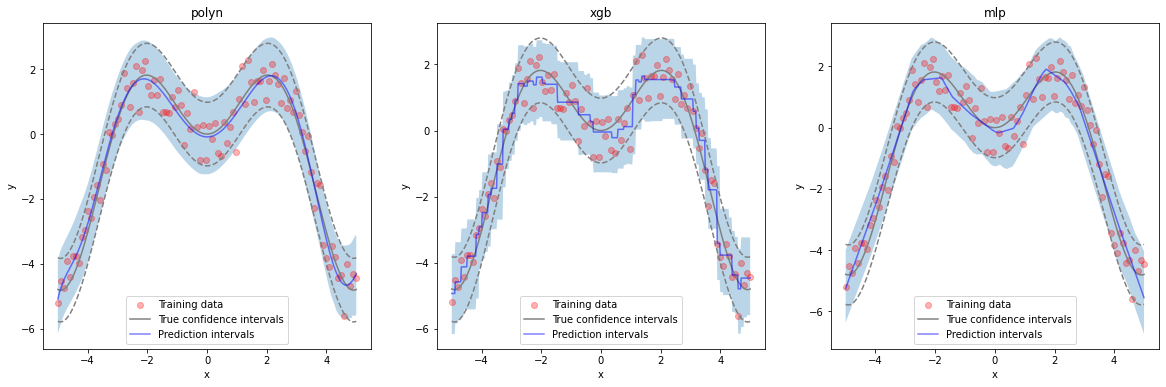

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
for name, ax in zip(model_names, axs):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        1.96*noise,
        y_pred[name].ravel(),
        y_pis[name][:, 0, 0].ravel(),
        y_pis[name][:, 1, 0].ravel(),
        ax=ax,
        title=name
    )

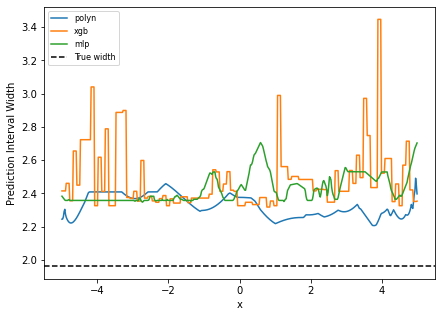

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for name in model_names:
    ax.plot(X_test, y_pis[name][:, 1, 0] - y_pis[name][:, 0, 0])
ax.axhline(1.96*2*noise, ls="--", color="k")
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
ax.legend(model_names + ["True width"], fontsize=8);

As expected with the CV+ method, the prediction intervals are a bit 
conservative since they are slightly wider than the true intervals.
However, the CV+ method on the three models gives very promising results 
since the prediction intervals closely follow the true intervals with $x$. 